In [29]:
# ========================================
# Predecir tipo de generación según cmg
# ========================================

# Importar librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [30]:
# Cargar dataset
df = pd.read_csv("D:\\DOCUMENTOS UNIVERSIDAD\\IA\\proyecto\\cmg_gen_barra.csv")
df.head()

,periodo,dia,hora,minuto,nombre_barra,generacion_kwh,cmg_peso_kwh,tipo_gen
0,2024-07-01,1,1,0,A.CLARAS______066,-125.503,48.11625,Termica
1,2024-07-01,1,1,0,A.HOSPICIO____013,225.330,53.35975,HidroeléctricaPasada
2,2024-07-01,1,1,0,A.NEGRAS______066,-2.205,48.11625,Fotovoltaico
3,2024-07-01,1,1,0,A.NEGRAS______066,-3.397,48.11625,Termica
4,2024-07-01,1,1,0,ACONCAGUA_1___012,876.837,48.62946,HidroeléctricaPasada


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17602032 entries, 0 to 17602031
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         object 
 1   dia             int64  
 2   hora            int64  
 3   minuto          int64  
 4   nombre_barra    object 
 5   generacion_kwh  float64
 6   cmg_peso_kwh    float64
 7   tipo_gen        object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.0+ GB


In [32]:
# Exploración inicial

print('\nDimensiones:', df.shape)
print('\nColumnas:', df.columns.tolist())
print('\nValores nulos:')
print(df.isnull().sum())
print('\nResumen estadístico:')
df.describe()


Dimensiones: (17602032, 8)

Columnas: ['periodo', 'dia', 'hora', 'minuto', 'nombre_barra', 'generacion_kwh', 'cmg_peso_kwh', 'tipo_gen']

Valores nulos:
periodo           0
dia               0
hora              0
minuto            0
nombre_barra      0
generacion_kwh    0
cmg_peso_kwh      0
tipo_gen          0
dtype: int64

Resumen estadístico:


,dia,hora,minuto,generacion_kwh,cmg_peso_kwh
count,1.760203e+07,1.760203e+07,1.760203e+07,1.760203e+07,1.760203e+07
mean,1.571127e+01,1.250174e+01,2.250000e+01,3.905844e+03,4.922092e+01
std,8.793832e+00,6.923275e+00,1.677051e+01,1.337205e+04,5.316316e+01
min,1.000000e+00,1.000000e+00,0.000000e+00,-4.826875e+04,0.000000e+00
25%,8.000000e+00,7.000000e+00,1.125000e+01,-2.195000e+00,0.000000e+00
50%,1.600000e+01,1.300000e+01,2.250000e+01,0.000000e+00,5.463576e+01
75%,2.300000e+01,1.900000e+01,3.375000e+01,1.836184e+03,7.123151e+01
max,3.100000e+01,2.500000e+01,4.500000e+01,3.766280e+05,1.001015e+03


El dataset contempla datos cada 15 minutos, para nuestro caso consideraremos solo los minutos = 0, es decir un análisis horario, debido a una falta de poder de computo.

Además, eliminamos la columna `nombre_barra` porque sabemos que no aporta información adicional.

In [33]:
# Reducción de filas

df = df[df['minuto'] == 0] # Quedarse solo con los minutos == 0
df = df.drop(['nombre_barra'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4400508 entries, 0 to 17600195
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   periodo         object 
 1   dia             int64  
 2   hora            int64  
 3   minuto          int64  
 4   generacion_kwh  float64
 5   cmg_peso_kwh    float64
 6   tipo_gen        object 
dtypes: float64(2), int64(3), object(2)
memory usage: 268.6+ MB


A continuación convertiremos la columna periodo a datetime para luego extraer el año y el mes.

In [34]:
df['periodo'] = pd.to_datetime(df['periodo'])
df['año'] = df['periodo'].dt.year
df['mes'] = df['periodo'].dt.month

df.head()

,periodo,dia,hora,minuto,generacion_kwh,cmg_peso_kwh,tipo_gen,año,mes
0,2024-07-01,1,1,0,-125.503,48.11625,Termica,2024,7
1,2024-07-01,1,1,0,225.330,53.35975,HidroeléctricaPasada,2024,7
2,2024-07-01,1,1,0,-2.205,48.11625,Fotovoltaico,2024,7
3,2024-07-01,1,1,0,-3.397,48.11625,Termica,2024,7
4,2024-07-01,1,1,0,876.837,48.62946,HidroeléctricaPasada,2024,7


Eliminar columnas originales que ya no usaremos y reordenarlas.

In [35]:
df.drop(['periodo', 'minuto'], axis=1, inplace=True)

df = df[['año', 'mes', 'dia', 'hora', 'generacion_kwh', 'cmg_peso_kwh', 'tipo_gen']]

df.head()

,año,mes,dia,hora,generacion_kwh,cmg_peso_kwh,tipo_gen
0,2024,7,1,1,-125.503,48.11625,Termica
1,2024,7,1,1,225.330,53.35975,HidroeléctricaPasada
2,2024,7,1,1,-2.205,48.11625,Fotovoltaico
3,2024,7,1,1,-3.397,48.11625,Termica
4,2024,7,1,1,876.837,48.62946,HidroeléctricaPasada


Normalizar nombres en columna `tipo_gen` para evitar incongruencias.

In [36]:
df['tipo_gen'] = df['tipo_gen'].str.lower().str.strip()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4400508 entries, 0 to 17600195
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   año             int32  
 1   mes             int32  
 2   dia             int64  
 3   hora            int64  
 4   generacion_kwh  float64
 5   cmg_peso_kwh    float64
 6   tipo_gen        object 
dtypes: float64(2), int32(2), int64(2), object(1)
memory usage: 235.0+ MB


Entrenamiento y Evaluación

In [38]:
from sklearn.model_selection import train_test_split

# Dividir datos
X = df.drop('tipo_gen', axis=1)
y = df['tipo_gen']

# Escalar los datos para comparar features entre sí
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index)

# Calculamos PCA
pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X), index=X.index)

Graficamos los primeros componentes del PCA()

C:\Users\fsepu\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


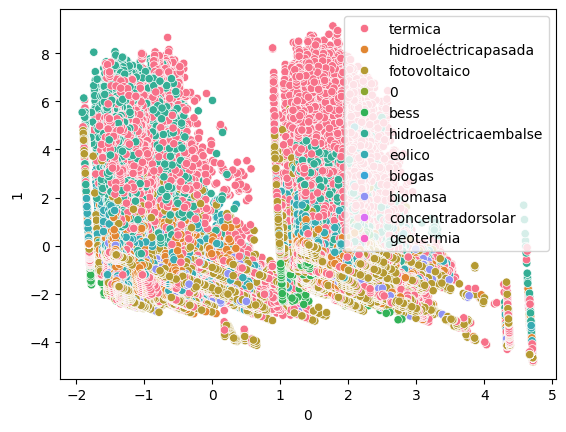

In [39]:
sns.scatterplot(X_pca, x=0, y=1, hue=(y).astype(str))
plt.legend()
plt.show()

La varianza explicada por cada componente del PCA nos indica que necesitamos al menos 3 componentes para alcanzar >80%.

In [40]:
exp_var = pd.DataFrame(pca.explained_variance_ratio_, columns=['explained_variance'])
exp_var['acumulativo'] = exp_var.explained_variance.cumsum()
exp_var

,explained_variance,acumulativo
0,0.339737,0.339737
1,0.173393,0.513130
2,0.167938,0.681068
3,0.163831,0.844899
4,0.141111,0.986010
5,0.013990,1.000000


Apartamos todos los registros que tengan etiqueta: `fotovoltaico`, `termica`, `hidroeléctricapasada` y `hidroeléctricaembalse`.

In [41]:
# Buscamos los elementos que cumplen la condición
sample_index = y[(y == 'fotovoltaico') | (y == 'termica') | (y == 'hidroeléctricapasada') |
                 (y == 'hidroeléctricaembalse')].index

# Apartamos los elementos con esos índices
X_sample = X_pca.loc[sample_index]
y_sample = y.loc[sample_index]

Entrenamos el modelo de clasificación.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

C:\Users\fsepu\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


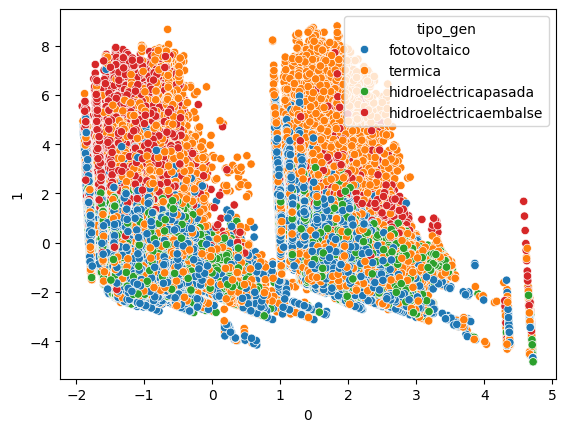

In [43]:
sns.scatterplot(X_train, x=0, y=1, hue=(y_train).astype(str))
plt.show()

Utilizamos el algoritmo KNN para clasificar cada punto del test en función de los vecinos más cercanos.

In [44]:
knn = KNeighborsClassifier(n_neighbors=5, weights= 'distance')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[417863   2956  51255  79701]
 [  4995   8065   5178   5585]
 [ 78060   3148 116573  38944]
 [101595   3789  27742 154957]]
                       precision    recall  f1-score   support

         fotovoltaico       0.69      0.76      0.72    551775
hidroeléctricaembalse       0.45      0.34      0.39     23823
 hidroeléctricapasada       0.58      0.49      0.53    236725
              termica       0.56      0.54      0.55    288083

             accuracy                           0.63   1100406
            macro avg       0.57      0.53      0.55   1100406
         weighted avg       0.63      0.63      0.63   1100406



Ahora utilizaremos Decision Tree sin PCA.

In [45]:
df = pd.read_csv("D:\\DOCUMENTOS UNIVERSIDAD\\IA\\proyecto\\cmg_gen_barra.csv")
df = df[df['minuto'] == 0] # Quedarse solo con los minutos == 0
df = df.drop(['nombre_barra'], axis=1)
df['periodo'] = pd.to_datetime(df['periodo'])
df['año'] = df['periodo'].dt.year
df['mes'] = df['periodo'].dt.month
df.drop(['periodo', 'minuto'], axis=1, inplace=True)
df = df[['año', 'mes', 'dia', 'hora', 'generacion_kwh', 'cmg_peso_kwh', 'tipo_gen']]
df['tipo_gen'] = df['tipo_gen'].str.lower().str.strip()

X = df.drop('tipo_gen', axis=1)
y = df['tipo_gen']

In [46]:
sample_index = y[(y == 'fotovoltaico') | (y == 'termica') | (y == 'hidroeléctricapasada') |
                 (y == 'hidroeléctricaembalse')].index

# Apartamos los elementos con esos índices
X_sample = X_pca.loc[sample_index]
y_sample = y.loc[sample_index]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

In [48]:
model = DecisionTreeClassifier(max_depth= 50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[405239   4737  65020  76779]
 [  4583   8310   4777   6153]
 [ 66290   5009 121455  43971]
 [ 68825   4925  31715 182618]]
                       precision    recall  f1-score   support

         fotovoltaico       0.74      0.73      0.74    551775
hidroeléctricaembalse       0.36      0.35      0.36     23823
 hidroeléctricapasada       0.54      0.51      0.53    236725
              termica       0.59      0.63      0.61    288083

             accuracy                           0.65   1100406
            macro avg       0.56      0.56      0.56   1100406
         weighted avg       0.65      0.65      0.65   1100406

